# Predict of Reaction Density and Evolution of Reaction Density

In [1]:
import re

import matplotlib.pyplot as plt
import pandas as pd

## Load dataset

Beside loading, we also remove some time steps which do not fall into the regular intervals of the macro-time steps.

In [2]:
dataset = pd.read_csv('C:/MyData/Versetzungsdaten/sampled_voxel_data_size2400_order2_speedUp2.csv')
dataset.drop(columns=list(dataset)[0], inplace=True) # drop 1st column (unnamed id column)
print('Number of time steps before cleaning:', dataset['time'].nunique())
dataset = dataset[dataset['time'] % 50 == 0] # remove irregular time steps
print('Number of time steps after cleaning:', dataset['time'].nunique())
print('(Rows, columns):', dataset.shape)

Number of time steps before cleaning: 300
Number of time steps after cleaning: 298
(Rows, columns): (37250, 2330)


## Add delta columns

In contrast to the `delta_sampled_merged` dataset, we do not have any pre-defined difference columns here.
Thus, we add them.

Note that we support deltas of more than one macro time-step.
Else, we could simply have used the history features `0_xyz` in the computation (without need for grouping).
Later, we'll use the deltas as one possible prediction target.
The bigger the delta, the better prediction results usually become.

Also, note that the delts are defined between future time step and current time step instead current time step and past time step.
This is different in our notebook for the other dataset.

In [3]:
delta_steps = 20
dataset.sort_values(by='time', inplace=True)
dataset_grouped = dataset.groupby(['pos_x', 'pos_y', 'pos_z'])
for quantity in ['coll', 'glissile', 'lomer']:
    dataset['delta_' + quantity] = dataset_grouped[quantity].transform(lambda x: x.shift(-delta_steps) - x)
del dataset_grouped

## Define features and target

We consider to prediction scenarios:
- absolute reaction density (which is not really interesting according to a domain expert)
- evolution of reaction density, i.e., difference from some point in time to another point in time (which probably is more difficult to predict)

The feature sets are slightly different than for the `delta_sampled_merged` dataset:
- We have different physical quantities in the dataset.
- Naming conventions of features differ.

In [4]:
prediction_problems = []

### Subset dataset

To have a more homogenous dataset (in particular, for the evolution scenario), we select a subset of macro-time steps without gaps between them.
This was also proposed by a domain expert.
We select the largest of the time-step subsets.
Note that we also need to prune the last time steps in that subset, because there will the time gaps in their (forward-oriented) prediction horizon.

In [5]:
times = pd.DataFrame({'time': dataset['time'].sort_values().unique()})
times['time_diff'] = times - times.shift()
times['group'] = (times['time_diff'] != 50).cumsum() # macro-time step bigger than usual
longest_group = times.groupby('group').size().idxmax()
timestamps = list(times[times['group'] == longest_group].time)[:-delta_steps] # longest sequence, without last elements
print('Longest number of consecutive timestamps with sufficient history available:', len(timestamps))
dataset = dataset[dataset.time.isin(timestamps)]
print('New dataset shape:', dataset.shape)

Longest number of consecutive timestamps with sufficient history available: 38
New dataset shape: (4750, 2333)


Alternatively, we could also select all macro-time steps where we have data for the prediction horizon (specific step in future).
This also ensures we have valid data for each prediction time, but overall combines data which might be largely apart, as there might be larger gaps between the selected time steps.

In [6]:
# times = pd.DataFrame({'time': dataset['time'].sort_values().unique()})
# times['time_diff'] = times - times.shift()
# times['group'] = (times['time_diff'] != 50).cumsum()
# # For each group, remove the last "delta_steps" elements:
# timestamps = list(times.groupby('group').apply(lambda x: x.drop(labels=x.index[-delta_steps:]))['time'])
# dataset = dataset[dataset.time.isin(timestamps)]
# print('New dataset shape:', dataset.shape)

### Prediction target: Absolute reaction density

We don't need to sum over the slip systems for this dataset, as we don't have slip-system-specific information for the reaction densities.
We exclude some features from prediction, in particular, values from the previous macro-time step and deltas.

In [7]:
target = 'glissile'
features = [x for x in list(dataset) if not target in x] # exclude if feature name contains the target string
features = [x for x in features if re.search('^([0-9]+)_', x) is None] # exclude historic features
features = [x for x in features if not 'delta' in x] # exclude delta features
features = [x for x in features if not 'pos_' in x and x != 'time'] # exclude position and time
prediction_problems.append({'target': target, 'features': features})

### Prediction target: Evolution of reaction density

Similar procedure.
We only consider values from the previous macro-time step as features.

In [8]:
target = 'delta_glissile'
features = [x for x in list(dataset) if not target in x] # exclude if feature name contains the target string
features = [x for x in features if re.search('^([0-9]+)_', x) is None] # exclude historic features
prediction_problems.append({'target': target, 'features': features})
dataset.dropna(subset=[target], inplace=True) # just a safeguard, usually these rows should have already been dropped earlier

## Run prediction pipeline

We try several regression models with a time-based holdout split.
Currently, we don't have any other pre-processing in place than our definition of the feature set.

In [9]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

models = {
    'Dummy': DummyRegressor(strategy='mean'),
    'Decision tree': DecisionTreeRegressor(),
    'Linear regression': LinearRegression(),
    'xgboost': XGBRegressor(),
}

max_train_time = dataset['time'].quantile(q=0.8)
np.random.seed(25)
results = []
for problem in prediction_problems:
    X_train = dataset[dataset['time'] <= max_train_time][problem['features']]
    y_train = dataset[dataset['time'] <= max_train_time][problem['target']]
    X_test = dataset[dataset['time'] > max_train_time][problem['features']]
    y_test = dataset[dataset['time'] > max_train_time][problem['target']]
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        train_score = r2_score(y_true=y_train, y_pred=pred_train)
        pred_test = model.predict(X_test)
        test_score = r2_score(y_true=y_test, y_pred=pred_test)
        results.append({'target': problem['target'], 'model': model_name,
                        'train_score': train_score, 'test_score': test_score})
results = pd.DataFrame(results)

## Evaluate

We tabulate and plot the results.
Predicting evolution is much harder than predicting absolute values.

           target              model  train_score  test_score
0        glissile              Dummy     0.000000   -0.016663
1        glissile      Decision tree     1.000000    0.970537
2        glissile  Linear regression     0.986815    0.982746
3        glissile            xgboost     0.999910    0.983968
4  delta_glissile              Dummy     0.000000   -0.010872
5  delta_glissile      Decision tree     1.000000    0.534170
6  delta_glissile  Linear regression     0.744209    0.643986
7  delta_glissile            xgboost     0.996691    0.722037

(for a delta of 20 macro-time steps == 1000 micro-time steps)


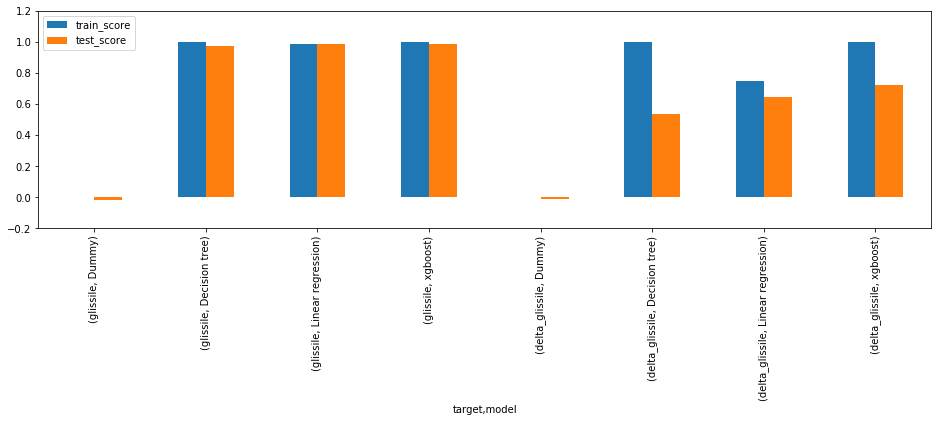

In [10]:
print(results)
print('\n(for a delta of ' + str(delta_steps) + ' macro-time steps == ' + str(delta_steps * 50) + ' micro-time steps)')
results.set_index(['target', 'model']).plot(kind='bar', figsize=(16, 4), ylim=(-0.2, 1.2)) # alternative to indexing: xticks
plt.show()